<a href="https://colab.research.google.com/github/julia-lukasiewicz-pater/gpt-wiki-features/blob/main/Code/GPT_wiki_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Exploring and Analyzing Linguistic Differences between Human-generated and AI-generated Texts**

In this Colab notebook we embark on an exploration and analysis of human-generated versus AI-generated texts. We dive into the data to uncover some insights and patterns that shed light on how AI-generated text differs from that written by a human.

For the analysis, we'll be using a HuggingFace wiki-GPT-features dataset that contains short texts from Wikipedia and their Wikipedia-styled counterparts generated by ChatGPT. 

The aim of this analysis is to discover the key differences between those two types of texts using some computational linguistics metrics.

Whether you're a data enthusiast, a researcher, or simply someone intrigued by the recent advances in the field of Large Language Models, this notebook hopefully provides an opportunity to explore the nuances and uncover valuable knowledge. Feel free to dive in, interact with the code, and explore!

Let's embark on this journey!

DESCRIPTION OF THE DATASET

The dataset we are using contains 300K text examples, of which the first 150K are from Wikipedia and the next 150K are the corresponding texts generated by ChatGPT. 

A number of linguistic measures, i.e. metrics of readability, linguistic richness, etc., were calculated for each text. In total, the dataset contains 48 metrics.

For a more in-depth look at this dataset, consult its page on HugginFace or take a peek at the second notebook.

The layout of this notebook is as follows:

* We first define a simple interactive dashboard using the `ipywidgets` library, which will help us to familiarise ourselves with all the variables in a convenient way.

* Next, we will examine the predictive power of these variables in a classification task using two `XGBoost` models.

# Exploring variables with a dashboard

## Setting up the dashboard

Firstly, we will install and import the libraries needed to create the dashboard.

In [ ]:
!pip install datasets
!pip install statannotations

In [ ]:
from datasets import load_dataset
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from scipy.stats import ks_2samp
#from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import ipywidgets as widgets
from IPython.display import display, clear_output
from statannotations.Annotator import Annotator

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Następnie ładujemy `GPT-wiki-intro-features` dataset z HuggingFace i przeobrażamy go w Pandas dataframe.


In [ ]:
final_dataset = load_dataset("julia-lukasiewicz-pater/GPT-wiki-intro-features")
final_dataset = pd.DataFrame(final_dataset['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/julia-lukasiewicz-pater___csv/julia-lukasiewicz-pater--GPT-wiki-intro-features-1bc441433a6f797f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In the following steps, we define functions for four different types of plots:

* boxplots
* histplots
* correlation heatmap
* scatterplots with regression line

These graphs will allow us to examine the distributions of variables.

In [ ]:
def codes():
  code = {'within_GPT': [1,1], 'within_Wikipedia':[0,0], 'between':[1,0]}
  code_names = {'within_GPT':['chatGPT', 'chatGPT'], 'within_Wikipedia':['Wikipedia','Wikipedia'], 'between':['chatGPT', 'Wikipedia']}
  return code, code_names

In [ ]:
def compute_statistic(sample1, sample2):

  statistic, p_value = wilcoxon(sample1, sample2)
  sig = p_value < 0.05
  p_dict = {True:"< 0.05", False: '> 0.0'}
  return statistic, p_dict[sig]


In [ ]:
def compare_boxplots(df, variable1, variable2, label, **kwargs):

  code, code_names = codes()
  y_lim = kwargs.get('y_lim', None)


  if variable1 == variable2:
    if label == 'between':

      data1 = df[df['class'] == 1][variable1]
      data2 = df[df['class'] == 0][variable1]

      #statistic, p = compute_statistic(data1,data2, 'mw')
      statistic, p = compute_statistic(data1,data2)

      plot = sns.boxplot(data = df, x = 'class', y = variable1)
      plt.xticks([1,0], ['chatGPT', 'Wikipedia'], rotation = 90)
      if y_lim:
        plot.set(ylim = (0,y_lim))
      else:
     
        annotator = Annotator(plot, [(0,1)], data = df, x = 'class', y = variable1, verbose = False)
        #annotator.annotate_custom_annotations([f'Mann-Wh-U: {statistic:.3f}, p: {p}'])
        annotator.annotate_custom_annotations([f'WT: {statistic:.3f}, p: {p}'])
      
    else:

      #The same variable, the same data range, one plot only

      df = df[df['class'] == code[label][0]][[variable1]]
      df.columns = [f'{variable1}_{code_names[label][0]}']
      plot = sns.boxplot(data = df)
      if y_lim:
        plot.set(ylim = (0,y_lim))
      plot.show()
  
  else:
    if label == 'between':
      data1 = df[df['class'] == 1][variable1]
      data2 = df[df['class'] == 0][variable1]

      #statistic, p = compute_statistic(data1,data2, 'mw')
      statistic, p = compute_statistic(data1,data2)

      df = df[df['class'] == code[label][0]][[variable1, variable2]]
      df.columns = [f'{variable1}_{code_names[label][0]}', f'{variable2}_{code_names[label][1]}']
      plot = sns.boxplot(data = df)
      if y_lim:
        plot.set(ylim = (0,y_lim))
      else:
        annotator = Annotator(plot, [(f'{df.columns[0]}', f'{df.columns[1]}')], data = df, verbose = False)
        #annotator.annotate_custom_annotations([f'Mann-Wh-U: {statistic:.3f}, p: {p}'])
        annotator.annotate_custom_annotations([f'WT: {statistic:.3f}, p: {p}'])

    else:
      data1 = df[df['class'] == code[label][0]][variable1]
      data2 = df[df['class'] == code[label][1]][variable2]

      #statistic, p = compute_statistic(data1,data2, 'mw')
      statistic, p = compute_statistic(data1,data2)


      df = df[[variable1, variable2]]
      df.columns = [f'{variable1}_{code_names[label][0]}', f'{variable2}_{code_names[label][1]}']
    
    
      
      plot = sns.boxplot(data = df)
      if y_lim:
        plot.set(ylim = (0,y_lim))
      else:
        annotator = Annotator(plot, [(f'{df.columns[0]}', f'{df.columns[1]}')], data = df, verbose = False)
        #annotator.annotate_custom_annotations([f'Mann-Wh-U: {statistic:.3f}, p: {p}'])
        annotator.annotate_custom_annotations([f'WT: {statistic:.3f}, p: {p}'])

In [ ]:
def compare_histplots(df, variable1,variable2, label, **kwargs):

  code, code_names = codes()
  x_lim = kwargs.get('x_lim', None)
  y_lim = kwargs.get('y_lim', None)
  #df= df.sample(n = 10000, random_state = 42)

 


  if variable1 == variable2:
    if label == 'between':

      data1 = df[df['class'] == 1][variable1]
      data2 = df[df['class'] == 0][variable1]

      
      #statistic, p = compute_statistic(data1,data2, 'ks')
      statistic, p = compute_statistic(data1,data2)
      try:
        plot = sns.histplot(data = df, x = variable1, hue = 'class', log_scale = True)
      except ValueError:
        plt.clf()
        plot = sns.histplot(data = df, x = variable1, hue = 'class')
      
      plt.legend(labels = ['chatGPT','Wikipedia'])
      if x_lim:
        plot.set(xlim = (0,x_lim))
      if y_lim:
        plot.set(ylim = (0,y_lim))
      #plt.title(f'KS: {statistic:.3f}, p: {p}')
      plt.title(f'WT: {statistic:.3f}, p: {p}')
      
  
    else:
      #The same variable, the same data range, one plot only

      df = df[df['class'] == code[label][0]][[variable1]]
      df.columns = [f'{variable1}_{code_names[label][0]}']
      plot = sns.histplot(data = df)
      

      if x_lim:
        plot.set(xlim = (0,x_lim))
      if y_lim:
        plot.set(ylim = (0,y_lim))

      plt.show()
  
      


  else:
    if label == 'between':
      data1 = df[df['class'] == 1][variable1]
      data2 = df[df['class'] == 0][variable1]

      #statistic, p = compute_statistic(data1,data2, 'ks')
      statistic, p = compute_statistic(data1,data2)

      df = df[df['class'] == code[label][0]][[variable1, variable2]]
      df.columns = [f'{variable1}_{code_names[label][0]}', f'{variable2}_{code_names[label][1]}']
      try:
        plot = sns.histplot(data = df, log_scale = True)
      except ValueError:
        plt.clf()
        plot = sns.histplot(data = df)
      if x_lim:
        plot.set(xlim = (0,x_lim))
      if y_lim:
        plot.set(ylim = (0,y_lim))
      #plt.title(f'KS: {statistic:.3f}, p: {p}')
      plt.title(f'WT: {statistic:.3f}, p: {p}')
    
      


    else:
      data1 = df[df['class'] == code[label][0]][variable1]
      data2 = df[df['class'] == code[label][1]][variable2]


      #statistic, p = compute_statistic(data1,data2, 'ks')
      statistic, p = compute_statistic(data1,data2)

      df = df[[variable1, variable2]]
      df.columns = [f'{variable1}_{code_names[label][0]}', f'{variable2}_{code_names[label][1]}']
    
    
      try:
        plot = sns.histplot(data = df, log_scale = True)
      except ValueError:
        plt.clf()
        plot = sns.histplot(data = df)
      if x_lim:
        plot.set(xlim = (0,x_lim))
      if y_lim:
        plot.set(ylim = (0,y_lim))

      #plt.title(f'KS: {statistic:.3f}, p: {p}')
      plt.title(f'WT: {statistic:.3f}, p: {p}')
    



In [ ]:
def correlation_heatmap(df, which):
  plt.figure(figsize=(10,7))
  df = df.dropna()
  if which == 'within_GPT':
    df = df[df['class'] == 1]
    df = df.drop(['class', 'text', 'Unnamed: 0'], axis= 1)
    plot = sns.heatmap(np.corrcoef(df.sample(n=3000, random_state = 42).to_numpy(), rowvar=False), xticklabels=df.columns, yticklabels = df.columns).set(title = 'Correlation of variables for chatGPT data')
    plt.tick_params(axis = 'x', direction = 'inout', bottom = True, top = False)
    plt.tick_params(axis = 'y', direction = 'inout', left = True, right = False)
  elif which == 'within_Wikipedia':
    df = df[df['class'] == 0]
    df = df.drop(['class', 'text', 'Unnamed: 0'], axis= 1)
    plot = sns.heatmap(np.corrcoef(df.sample(n=3000, random_state = 42).to_numpy(), rowvar=False), xticklabels=df.columns, yticklabels = df.columns).set(title = 'Correlation of variables for Wikipedia data')
  elif which == 'between':
    df = df.drop(['class', 'text', 'Unnamed: 0'], axis= 1)
    plot = sns.heatmap(np.corrcoef(df.sample(n=3000, random_state = 42).to_numpy(), rowvar=False), xticklabels=df.columns, yticklabels = df.columns).set(title = 'Correlation of variables for all data')
  
  return plot
  



In [ ]:
def regression(df, variable1, variable2, label, line = False, order = None, **kwargs):

  code, code_names = codes()


  var1 = df[df['class'] == code[label][0]][variable1].reset_index(drop =True)
  var0 = df[df['class'] == code[label][1]][variable2].reset_index(drop = True)
  var = pd.concat([var1,var0],axis=1)
  var.columns = [f'{variable1}_{code_names[label][0]}', f'{variable2}_{code_names[label][1]}']


  x_lim = kwargs.get('x_lim',None)
  y_lim = kwargs.get('y_lim', None)
  if not line:
    plot = sns.scatterplot(x = f'{variable1}_{code_names[label][0]}', y = f'{variable2}_{code_names[label][1]}', data = var, s = 10)
    if x_lim:
      plot.set(xlim = (0,x_lim))
    if y_lim:
      plot.set(ylim = (0,y_lim))
  else:
    plot = sns.lmplot(x = f'{variable1}_{code_names[label][0]}', y = f'{variable2}_{code_names[label][1]}', data = var, order = order, scatter_kws={"s": 5}, 
             line_kws = {'color':'red'}, x_ci = "ci", ci = 95)
    if x_lim:
      plot.set(xlim = (0,x_lim))
    if y_lim:
      plot.set(ylim = (0,y_lim))


In [ ]:
def display_variables(df):
  return df.columns[3:]

The cell below sets up the dashboard.

In [ ]:
style_long = {'description_width': 'initial'}

#boxplots
variable1_boxplots = widgets.Dropdown(options = display_variables(final_dataset), description = "Choose variables", style = style_long, layout = widgets.Layout(width = '20%'))
variable2_boxplots = widgets.Dropdown(options = display_variables(final_dataset), layout = widgets.Layout(width = '15%'))

how_boxplots = widgets.RadioButtons(
    options = ['within_GPT', 'within_Wikipedia', 'between'],
    description = "Choose an option",
    disabled = False,
    style = style_long
)


y_lim_box = widgets.IntText(
    value = None,
    min = 0,
    max = 300,
    step = 1, 
    disabled = False,
    description = 'Change the default y-axis limit',
    style = style_long
    
)

button_boxplots = widgets.Button(description = "Draw boxplot", button_style = 'success')

def draw_boxplot(button):
  selected_variable1 = variable1_boxplots.value
  selected_variable2 = variable2_boxplots.value
  selected_how = how_boxplots.value
  plot_params = {'y_lim':y_lim_box.value}
  boxplots_output.clear_output()

  with boxplots_output:
    compare_boxplots(final_dataset, selected_variable1, selected_variable2, selected_how, **plot_params)

boxplots_output = widgets.Output()
button_boxplots.on_click(draw_boxplot)

#histplots
variable1_histplots = widgets.Dropdown(options = display_variables(final_dataset), description = "Choose variables", style = style_long, layout = widgets.Layout(width = '80%'))
variable2_histplots = widgets.Dropdown(options = display_variables(final_dataset), layout = widgets.Layout(width = '50%'))

how_histplots = widgets.RadioButtons(
    options = ['within_GPT', 'within_Wikipedia', 'between'],
    description = "Choose an option",
    disabled = False,
    style = style_long
)

x_lim_histplot = widgets.IntText(
    value = None,
    min = 0,
    max = 100,
    step = 1, 
    disabled = False,
    description = 'Change the default x-axis limit',
    style = style_long   
)


y_lim_histplot = widgets.IntText(
    value = None,
    min = 0,
    max = 5000,
    step = 1, 
    disabled = False,
    description = 'Change the default y-axis limit',
    style = style_long
    
)

button_histplots = widgets.Button(description = "Draw histplot", button_style = 'success')

def draw_histplot(button):
  selected_variable1 = variable1_histplots.value
  selected_variable2 = variable2_histplots.value
  selected_how = how_histplots.value
  plot_params = {'x_lim':x_lim_histplot.value, 'y_lim':y_lim_histplot.value}

  histplot_output.clear_output()

  with histplot_output:
    compare_histplots(final_dataset, selected_variable1, selected_variable2, selected_how, **plot_params)

histplot_output = widgets.Output()
button_histplots.on_click(draw_histplot)

#regression
variable1_reg = widgets.Dropdown(options = display_variables(final_dataset), description = "Choose variables", style = style_long, layout = widgets.Layout(width = '100%'))
variable2_reg = widgets.Dropdown(options = display_variables(final_dataset), layout = widgets.Layout(width = '70%'))

order_widget = widgets.IntText(
    min = 1,
    value=1,
    description='Order:',
    disabled=False
)
if_regression = widgets.RadioButtons(
    options = ['Yes', "No"],
    description = "Draw a regression line",
    disabled=False,
    style = style_long
)
how_regression = widgets.RadioButtons(
    options = ['within_GPT', 'within_Wikipedia', 'between'],
    description = "Choose an option",
    disabled = False,
    style = style_long
)

x_lim_reg = widgets.IntText(
    value = None,
    min = 0,
    max = 300,
    step = 1, 
    disabled = False,
    description = 'Change the default x-axis limit',
    style = style_long   
)


y_lim_reg = widgets.IntText(
    value = None,
    min = 0,
    max = 300,
    step = 1, 
    disabled = False,
    description = 'Change the default y-axis limit',
    style = style_long
    
)

button_reg = widgets.Button(description = "Draw scatterplot", button_style = 'success')

def order_eventhandler(change):
  if change.new < 1:
    order_widget.value = 1

order_widget.observe(order_eventhandler, names = 'value')

def draw_regression(button):
  selected_variable1 = variable1_reg.value
  selected_variable2 = variable2_reg.value
  selected_how = how_regression.value
  plot_params = {'x_lim':x_lim_reg.value, 'y_lim':y_lim_reg.value}
  selected_line = if_regression.value
  selected_order = order_widget.value

  regression_output.clear_output()


  with regression_output:
    if selected_line == 'Yes':
      regression(final_dataset, selected_variable1, selected_variable2, selected_how, line = True, order = selected_order, **plot_params)
    else:
      regression(final_dataset, selected_variable1, selected_variable2, selected_how, **plot_params)

regression_output = widgets.Output()
button_reg.on_click(draw_regression)

#correlation
how_correlation = widgets.RadioButtons(
    options = ['within_GPT', 'within_Wikipedia', 'between'],
    description = "Choose an option",
    disabled = False,
    style = style_long
)

button_cor = widgets.Button(description = "Draw heatmap", style = style_long, button_style = 'success')

def draw_correlation(button):
  selected_which = how_correlation.value

  correlation_output.clear_output()

  with correlation_output:
    display(correlation_heatmap(final_dataset, selected_which))

correlation_output = widgets.Output()
button_cor.on_click(draw_correlation)

def func_clear(button):
  clear_output()
  tab = widgets.Tab([widgets.HBox([variable1_boxplots, variable2_boxplots, how_boxplots, y_lim_box, button_boxplots, button_clear]), 
                  widgets.GridBox([variable1_histplots, variable2_histplots, how_histplots, x_lim_histplot, y_lim_histplot, button_histplots,button_clear], layout = widgets.Layout(grid_template_columns = 'repeat(3,  350px)')),
                  widgets.GridBox([variable1_reg, variable2_reg, how_regression, x_lim_reg, y_lim_reg, order_widget, if_regression, button_reg,button_clear], layout = widgets.Layout(grid_template_columns = "repeat(3, 350px)")),
                  widgets.HBox([how_correlation, button_cor,button_clear]) ])

  tab.set_title(0, 'Boxplots')
  tab.set_title(1, 'Histplots')
  tab.set_title(2, 'Scatterplots')
  tab.set_title(3, 'Correlation heatmap')

  display(tab)



button_clear = widgets.Button(description = 'Clear the plot', button_style = 'warning')
button_clear.on_click(func_clear)

tab = widgets.Tab([widgets.HBox([variable1_boxplots, variable2_boxplots, how_boxplots, y_lim_box, button_boxplots, button_clear]), 
                  widgets.GridBox([variable1_histplots, variable2_histplots, how_histplots, x_lim_histplot, y_lim_histplot, button_histplots,button_clear], layout = widgets.Layout(grid_template_columns = 'repeat(3,  350px)')),
                  widgets.GridBox([variable1_reg, variable2_reg, how_regression, x_lim_reg, y_lim_reg, order_widget, if_regression, button_reg,button_clear], layout = widgets.Layout(grid_template_columns = "repeat(3, 350px)")),
                  widgets.HBox([how_correlation, button_cor,button_clear]) ])

tab.set_title(0, 'Boxplots')
tab.set_title(1, 'Histplots')
tab.set_title(2, 'Scatterplots')
tab.set_title(3, 'Correlation heatmap')


## Dashboard

HOW DOES IT WORK?

1. Select one of the four tabs to display a particular plot.
2. For the first three plot types, select the variables you want to visualise.
3. Select the data range: do you want to see the variables distributions for ChatGPT-generated texts only, Wikipedia texts only, or maybe you want to compare both classes?
4. For some plots, you can change the ranges of the x- and y-axes if you feel that their default values do not reflect the distributions in an informative way.
5. For scatterplots, you can also choose whether you want to draw a regression line. If yes, select also the regression order. 
6. Once you have selected all the options, press the corresponding `Draw` button and when you have viewed the plot, press `Clear the plot`. It might take some seconds to draw a plot, so be patient.

Voilà!

Boxplots and histplots also display the results of the Wilcoxon T test (non-parametric version of the paired student t-test) for both samples .



Run the cell below to display the dashboard!

In [ ]:
display(tab)

## Analysis

**In this section, we will take a brief look at how the distributions of the different variables differ depending on whether the texts were written by a human or by ChatGPT.** 

Let's start with the information theory measures. Intuitively, this is where we should find the biggest differences.

`spacy_perplexity` stores the values of the perplexity for the corresponding text calculated with the help of the `textdescriptives` library, which in turn is based on language models from [Spacy](https://spacy.io/).
Here, Wilcoxon T test is statistically significant, but due to the outlier in Wikipedia class being extremely far from the rest of the distribution, the graph is not very informative. After changing the y-axis range to `[0 ,3000]`, however, we see a sizable difference between the boxplots. The median for ChatGPT is close to 0! In contrast, the median for Wikipedia exceeds the 3rd quartile for ChatGPT. The ChatGPT boxplot is also much narrower, although there are also some outliers.

*How does this comparison look on the histplot?*
Wikipedia is gently right-skewed and centreed around $10^3$, while ChatGPT is asymmetrical, having two peaks, one a little over $10^1$ and the other around $10^3$. You can see a clear difference in the shape of the two distributions. Wikipedia pulls out much higher.

With scatterplots you have to play around a bit with the axis ranges to get more information. However, we can see that the highest value that ChatGPT reaches is around 1 million, whereas by default the y-axis is expressed on a scale of the order of $10^11$! Because of this large difference in scale, the points are condensed close to the x-axis. By reducing the scale on the y-axis, one can see that (not counting this one outlier, which is visible with the default settings), the highest values for Wikipedia are about $0.8*10^7$.

However, this metric applies to whole texts. But texts can vary in length -- most of them are between 100 and 300 words. Let's see what the distribution of the normalised perplexity looks like. To do this, we will select the variable `per_word_perplexity`.

*per_word_perplexity*

For boxplots, the above situation is repeated. The test is statistically significant, indicating a difference between the distributions of this variable in the two classes. To get a good look at the boxplots, restrict the y-axis to 20. Then again, it can be seen that the interquartile range for ChatGPT is much smaller than for Wikipedia, and the Wikipedia median slightly exceeds the 3rd quartile of ChatGPT. The upper whiskers and outliers reach much higher for Wikipedia.

Histplots resemble an unnormalised perplexity variable in shape. At first glance they appear to overlap more than before, but there is still a clear difference.

The scatterplots again show a large difference in values. Again, the more frequent high values for ChatGPT are in the range 50-150, while for Wikipedia in the range 2000-10000. 

Similar trends can also be seen when examining the other information theory variables, i.e. entropy and normalised bigram entropy. It is still Wikipedia that has a more concentrated distribution reaching higher values, and the ChatGPT distribution is flatter.

On this basis, it can be concluded that in this dataset, the texts from Wikipedia are characterised by a much higher information load than the texts generated by ChatGPT. The patterns we observed indicate that human-generated texts are more unpredictable and surprising.

*Dependency distance*

Let us now look at the mean dependency distance, that is, the average distance of each word from their dependent in a text. It is assumed that the longer the dependencies, the more syntactically complex the text is. For more details, take a peek at the [library](https://hlasse.github.io/TextDescriptives/dependencydistance.html) documentation used to calculate this measure.

Boxplots show that outliers reach much higher for Wikipedia than for ChatGPT. The Wilcoxon T test indicates a significant difference between both distributions. However, the boxplots themselves do not look well with the default y-axis settings. After constraining the range to 10, we see that the boxplots do not appear to be very different after all. They have a similar width, interquartile range and median (the median for Wikipedia is around the 3rd quartile of ChatGPT).

Histplots do not show such drastic differences as we saw with perplexity. The shapes of the distributions are almost identical and are slightly shifted from each other.

In summary, what we can learn from the plots is that the texts generated by ChatGPT are characterised by rather shorter mean dependency distances, usually around 2.5. In the case of Wikipedia, the most common values for this metric are slightly higher, but much higher valuse, i.e. from 10 upwards, are also more common.

*What about the metrics of readability and lexical diversity?*

The comparisons all look similar, i.e. Wilcoxon T test shows significant differences, the plots are always shifted relative to each other, although they have the same shape. On scatterplots, they tend to be concentrated in the bottom left corner and pulled upwards there, indicating that Wikipedia is more likely to have higher values (in cases where this makes sense, see e.g. flesch reading ease, where the plot looks the other way round).
Note, however, that the texts in this dataset are very short (no more than about 300 words) and such measures may not always be reliable in such a case (although the consensus seems to be that HDD and MTLD supposedly also work well on short texts; see e.g. [McCarthy & Jarvis 2010](https://link.springer.com/content/pdf/10.3758/BRM.42.2.381.pdf); in my simple experiments I've done in the past, at 250 words HDD was already practically reliable).

*Parts of speech*

The dataset contains several variables that indicate the proportion of a given part of speech (according to [universal tagset](http://www.lrec-conf.org/proceedings/lrec2012/pdf/274_Paper.pdf)) to all words.

In this class, non-significant differences can be found, e.g. for the variable number_of_DET(erminers), the Wilcoxon T test is non-significant, and the boxplots look almost identical. ChatGPT, however, is more right-skewed, as can be seen in the histplots.

An interesting observation, for example, is that many more texts generated by ChatGPT have no adjectives at all (ADJ) compared to Wikipedia. The same is true for adpositions (ADP).

*Summary*

Analysis of the other metrics shows mostly a recurring pattern -- in most cases, statistical test indicates a significant difference between the distributions of the variables in the two classes. More often than not, the distributions are similar in shape, i.e. they resemble a normal distribution, have a similar centre height and dispersion, but are shifted with respect to each other.
The analysis of these measures allows us to conclude that ChatGPT-generated texts are characterised by less creativity, in many respects they are poorer than texts written by humans. We found the biggest difference when analysing the information theory measures, where the distributions were characterised by a different shape, dispersion and a considerable shift relative to each other.

I encourage you to explore further! The dashboard not only allows comparisons between classes, but also within individual classes.


**Correlation**

Finally, let's take a look at which variables correlate with each other. The dashboard allows us to examine this question in three ways -- either between classes, i.e. considering all data, or within each class, i.e. selecting data from only one class.

Consider the first way, i.e. between classes. As you can see, there are some variables that correlate positively with each other. Correlation occurs between measures of lexical richness (hdd, mtld, mattr), between measures of readability (e.g. colemann_liau index, gunning_fog, flesch_kincaid_grade; flesch_reading_ease correlates negatively with them), and measures of information theory (entropy, spacy_perplexity etc.). Overall, the results of this analysis are not surprising, as variables that carry similar information are correlated.

The within-class analysis reveals the effects already observed, they only differ in strength.

# Classification using linguistic metrics

In this section, we will test whether the metrics we explored above are suitable as predictors in a binary classification task (Wikipedia versus ChatGPT).

We will define two models: a baseline model in which we apply all metrics from the dataset, and a model in which we do a bit of feature engineering, i.e. we average the correlating variables and thus reduce the dimensionality of the data.

We will use a powerful machine learning algorithm called XGBoost, which is known for its effectiveness in handling structured data and making accurate predictions. We will be utilizing the [XGBoost](https://xgboost.readthedocs.io/en/stable/) library, a popular implementation of the algorithm. One of the key advantages of XGBoost is its ability to examine feature importances. These importances indicate the relative contribution of each feature towards the prediction, helping us understand which variables are most influential in the model's decision-making process.

Again, we will start by importing the relevant libraries.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

## Baseline model

We start by defining a baseline model.

To do this, we define a pipeline `pipe1`, which allows us to fit our model in just a few lines of code!

Our preprocessing consists of several steps:

1. Removing unnecessary columns: the `Unnamed: 0` column is simply an index, and `text` contains the corresponding text for which the metrics were calculated -- these columns are not suitable for predictors. In addition, `ari` as well as `fog` are redundant because they contain the same information as two other columns, `automatex readability index` and `gunning_fog`, respectively. Since these first columns have missing data, the best solution is to simply delete them.
2. Change the 0s in the `dale_chall` column to `np.nan`: in this column, 0 indicates missing data (which can be checked in the X-code TODO). We will make this substitution for ease of imputing.
3. Random row shuffling.
4. Splitting the data into predictors and labels, and into training and test data.

We apply a pipeline on the data thus prepared, which imputes the missing data using the median and passes it to the XGBoost classifier.


In addition, we will optimize the model's hyperparameters using the `GridSearchCV` function. It exhaustively searches through a predefined grid of parameter values and evaluates the model's performance using cross-validation.

To learn more about XGBoost hyperparameters, see the [documentation](https://xgboost.readthedocs.io/en/stable/).

In [ ]:
dataset_dropped1 = final_dataset.drop(['Unnamed: 0', 'text', 'ari', 'fog'], axis = 1)
dataset_dropped1['dale_chall'] = dataset_dropped1['dale_chall'].replace(0,np.nan)
dataset_shuffled1 = dataset_dropped1.sample(frac=1, random_state=42)

X1 = dataset_shuffled1.drop(['class'], axis = 1)
y1 = dataset_shuffled1['class']





X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, train_size = 0.8, test_size = 0.2, random_state=42)

NOTE: you do not need to run the cell below, as this can take a long time and the grid search results have been saved and are discussed below. TODO

In [ ]:
pipe1 = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                 ('model', XGBClassifier(objective = 'binary:logistic', tree_method = "auto", grow_policy = 'depthwise'))])


param_grid_xg = {'model__n_estimators':[40, 50], 'model__max_depth':[10,20], 'model__reg_alpha':[0,1,4],
                'model__learning_rate':[0.3, 0.01]}





grid_search1 = GridSearchCV(pipe1, param_grid_xg, cv = 3, scoring = ['f1', 'accuracy'], verbose=3, refit = False)
grid_search1.fit(X_train1, y_train1)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END model__learning_rate=0.3, model__max_depth=10, model__n_estimators=40, model__reg_alpha=0; accuracy: (test=0.941) f1: (test=0.941) total time= 1.7min
[CV 2/3] END model__learning_rate=0.3, model__max_depth=10, model__n_estimators=40, model__reg_alpha=0; accuracy: (test=0.942) f1: (test=0.941) total time= 1.6min
[CV 3/3] END model__learning_rate=0.3, model__max_depth=10, model__n_estimators=40, model__reg_alpha=0; accuracy: (test=0.941) f1: (test=0.940) total time= 1.6min
[CV 1/3] END model__learning_rate=0.3, model__max_depth=10, model__n_estimators=40, model__reg_alpha=1; accuracy: (test=0.941) f1: (test=0.941) total time= 1.6min
[CV 2/3] END model__learning_rate=0.3, model__max_depth=10, model__n_estimators=40, model__reg_alpha=1; accuracy: (test=0.943) f1: (test=0.942) total time= 1.6min
[CV 3/3] END model__learning_rate=0.3, model__max_depth=10, model__n_estimators=40, model__reg_alpha=1; accuracy: (test=0.94

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy='dep...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'model__learning_rate': [0.3, 0.01],
                         'model__max_depth': [10, 20],
                         'model__n_estimators': [40, 50],
                         'model__reg_alpha': [0, 1, 4]},
             refit=False, scoring=['f1', 'accuracy'], verbose=3)

Poniżej zapisujemy

In [ ]:
pd.DataFrame(grid_search1.cv_results_).to_csv('/content/gdrive/MyDrive/CPM project final/final results/xgboost_30maj_bez_korelacji.csv')

In [ ]:
cv_results1 = pd.DataFrame(grid_search1.cv_results_)
best_params1 = cv_results1.sort_values(by = 'rank_test_f1').iloc[0]['params']

In [ ]:
keys1 = [feature.replace('model__','') for feature in best_params1.keys()]
best_params1 = dict(zip(keys, best_params1.values()))

In [ ]:
best_params1

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'reg_alpha': 4}

For the baseline model, the best hyperparameters found are


`{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'reg_alpha': 4}`

Odnajdziemy je w repozytorium, co robimy poniżej. TODO

In [ ]:
#tutaj kod, jak już będę miała na githubie, to sobie otworzę
best_params1 = {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'reg_alpha': 4}

Finally we can run the model!

In [ ]:
final_pipe1 = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                 ('model', XGBClassifier(objective = 'binary:logistic', tree_method = "auto", grow_policy = 'depthwise', **best_params1))])

final_pipe1.fit(X_train1, y_train1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

Let's save the evaluation metrics for the test dataset.

In [ ]:
#importances2 = final_pipe2._final_estimator.get_booster().get_score(importance_type='weight')
preds1 = final_pipe1.predict(X_test1)
f1_1 = f1_score(y_test1, preds1)
accuracy_1 = accuracy_score(y_test1,preds1)

In [ ]:
print('Evaluation of the first model:')
print(f'F1: {f1_1:.3f}, accuracy: {accuracy_1:.3f}')

Evaluation of the first model:
F1: 0.944, accuracy: 0.945


TODO SKOMENTUJ WYNIKI

We can now save the feature importances and use them for visualisation.

Note, that metrics whose importances were equal to 0, are not present in `final_importances`. E.g. *entropy* is not there!

In [ ]:
gain_dict = final_pipe1._final_estimator.get_booster().get_score(importance_type='gain')
feature_names = list(zip(range(0,47), X_train1.columns))
bare_importances = final_pipe1._final_estimator.feature_importances_

new = []
for i, feature in enumerate(feature_names):
  new.append((feature[0], feature[1], bare_importances[i]))


def if_zero_important(number):
  if number[2] == 0:
    return False
  return True

clean_features = list(filter(if_zero_important, new))
only_names = list(map(lambda x : x[1], clean_features))
final_importances = dict(zip(only_names, gain_dict.values()))
final_importances

{'spacy_perplexity': 17.82929229736328,
 'automated_readability_index': 3.6914007663726807,
 'per_word_spacy_perplexity': 9.837969779968262,
 'dependency_distance_mean': 4.189383506774902,
 'dependency_distance_std': 11.145751953125,
 'first_order_coherence': 3.8970820903778076,
 'second_order_coherence': 4.217934608459473,
 'smog': 3.6769378185272217,
 'prop_adjacent_dependency_relation_mean': 8.609813690185547,
 'prop_adjacent_dependency_relation_std': 2.717620372772217,
 'syllables_per_token_mean': 4.637401580810547,
 'token_length_std': 3.852966070175171,
 'token_length_median': 16.991180419921875,
 'sentence_length_median': 7.983609676361084,
 'syllables_per_token_std': 2.8708667755126953,
 'proportion_unique_tokens': 22.333650588989258,
 'top_ngram_chr_fraction_3': 31.701786041259766,
 'top_ngram_chr_fraction_2': 5.906988143920898,
 'top_ngram_chr_fraction_4': 18.005878448486328,
 'proportion_bullet_points': 8.123278617858887,
 'flesch_reading_ease': 3.003112316131592,
 'flesch_k

<Axes: xlabel='score'>

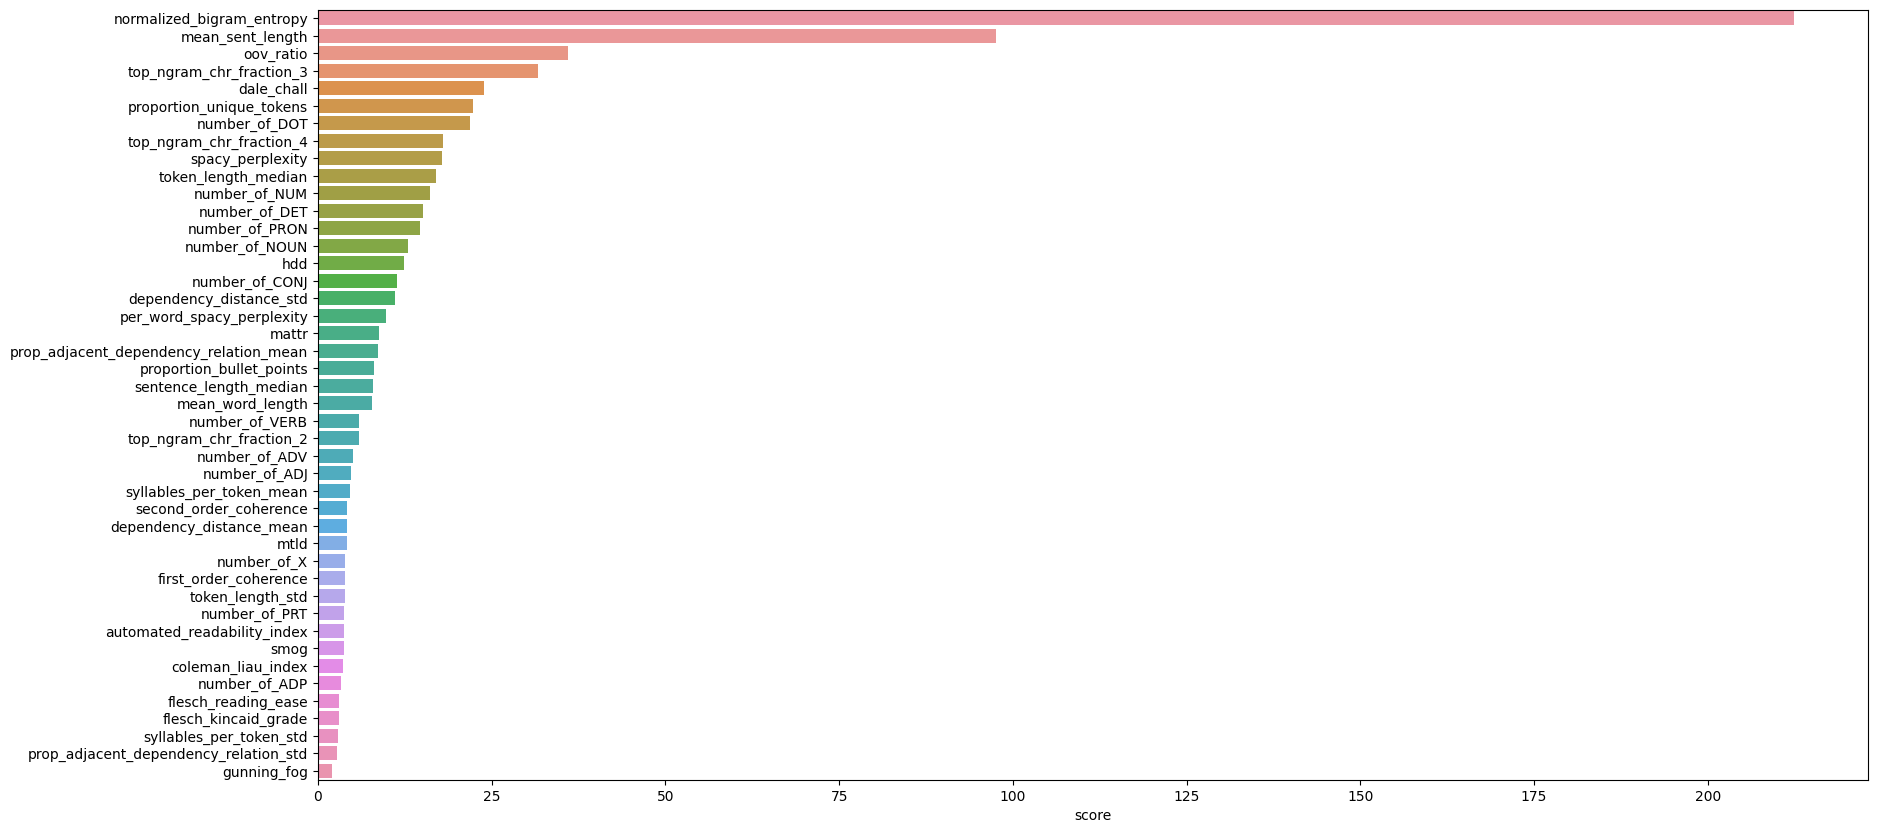

In [ ]:
#This code was inspired by https://stackoverflow.com/a/52777909
keys = list(final_importances.keys())
values = list(final_importances.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(data = data, x = 'score', y = data.index)

It turns out that the variable that contributes most to the predictive power of the first model is the *normalised_bigram_entropy* variable! This confirms our initial intuitions. However, next are the not-so-obvious variables, namely *mean_sent_length* (mean sentence length) and *oov_ratio* (out-of-vocabulary words ratio). Feel free to check their distributions again using the dashboard!

## Averaging correlated features

Let us define the functions with which we will average the correlated variables. We will use these functions later as pipeline components.

In [ ]:
def average_correlated(matrix):

  ease_features = ['automated_readability_index', 'smog', 'coleman_liau_index', 'gunning_fog', 'flesch_kincaid_grade', 'syllables_per_token_mean',
                   'syllables_per_token_median','mean_word_length', 'mean_sent_length', 'token_length_std', 'token_length_median', 'sentence_length_median',
                   'syllables_per_token_std', 'dale_chall']
  entropy_features = ['entropy', 'spacy_perplexity', 'per_word_spacy_perplexity', 'normalized_bigram_entropy']
  richness_features = ['hdd', 'mtld','mattr']
  top_n_gram_features = ['top_ngram_chr_fraction_2', 'top_ngram_chr_fraction_3', 'top_ngram_chr_fraction_4']

  coherence_features = ['first_order_coherence', 'second_order_coherence']

  
  ease_indices = [X2.columns.get_loc(name) for name in ease_features]
  entropy_indices = [X2.columns.get_loc(name) for name in entropy_features]
  
  richness_indices = [X2.columns.get_loc(name) for name in richness_features]
  top_n_gram_indices = [X2.columns.get_loc(name) for name in top_n_gram_features]
  coherence_indices = [X2.columns.get_loc(name) for name in coherence_features]

  ease = np.mean(matrix[:, ease_indices], axis = 1, keepdims = True)
  entropy_general = np.mean(matrix[:, entropy_indices], axis = 1, keepdims = True)
  richness = np.mean(matrix[:, richness_indices], axis = 1, keepdims = True)
  top_n_gram = np.mean(matrix[:, top_n_gram_indices], axis = 1, keepdims = True)
  coherence = np.mean(matrix[:, coherence_indices], axis = 1, keepdims = True)

 
  changed_features = ease_indices + entropy_indices + richness_indices + top_n_gram_indices + coherence_indices
  result = np.delete(matrix, [changed_features], axis = 1)

  result = np.append(result, ease, axis = 1)
  result = np.append(result, entropy_general, axis = 1)
  result = np.append(result, richness, axis = 1)
  result = np.append(result, top_n_gram, axis = 1)
  result = np.append(result, coherence, axis = 1)

  return result



In [ ]:
def new_feature_names(input_list):
  ease_features = ['automated_readability_index', 'smog', 'coleman_liau_index', 'gunning_fog', 'flesch_kincaid_grade', 'syllables_per_token_mean',
                   'syllables_per_token_median','mean_word_length', 'mean_sent_length', 'token_length_std', 'token_length_median', 'sentence_length_median',
                   'syllables_per_token_std', 'dale_chall']
  entropy_features = ['entropy', 'spacy_perplexity', 'per_word_spacy_perplexity', 'normalized_bigram_entropy']
  richness_features = ['hdd', 'mtld','mattr']
  top_n_gram_features = ['top_ngram_chr_fraction_2', 'top_ngram_chr_fraction_3', 'top_ngram_chr_fraction_4']

  coherence_features = ['first_order_coherence', 'second_order_coherence']

  changed_features = ease_features + entropy_features + richness_features + top_n_gram_features + coherence_features

  new_list = ['ease', 'entropy_general','richness','top_n_gram','coherence']
  deleted = list(set(input_list) - set(changed_features))
  result = deleted + new_list
  return result

Below we define a new pipeline. As before, its first component is the imputer, which replaces missing data with the corresponding median. Then we add new steps, the standard scaler, which standardises the variables, allowing for a more reliable average. The next step is our custom function, which averages the relevant variables. Finally, we apply the same model as last time.

Also, note that here we also remove one more column, namely `flesch_reading_ease`. Recall that it is strongly negatively correlated with many variables.

In [ ]:
dataset_dropped2 = final_dataset.drop(['Unnamed: 0', 'text', 'ari', 'fog', 'flesch_reading_ease'], axis = 1)
dataset_dropped2['dale_chall'] = dataset_dropped2['dale_chall'].replace(0,np.nan)
dataset_shuffled2 = dataset_dropped2.sample(frac=1, random_state=42)

X2 = dataset_shuffled2.drop(['class'], axis = 1)
y2 = dataset_shuffled2['class']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, train_size = 0.8, test_size = 0.2, random_state=42)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, train_size = 0.8, test_size = 0.2, random_state=42)

Again, you don't have to run the cell below, as its results are already saved.

In [ ]:
pipe2 = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                 ('scaler', StandardScaler()),
                 ('transformer', FunctionTransformer(average_correlated, feature_names_out = new_feature_names)),
                 ('model', XGBClassifier(objective = 'binary:logistic', tree_method = "auto", grow_policy = 'depthwise'))])


param_grid_xg = {'model__n_estimators':[40, 50], 'model__max_depth':[10,20], 'model__reg_alpha':[0,1,4],
                'model__learning_rate':[0.3, 0.01]}






grid_search2 = GridSearchCV(pipe2, param_grid_xg, cv = 3, scoring = ['f1', 'accuracy'], verbose=3, refit = False)
grid_search2.fit(X_train2, y_train2)

Tak jak wcześniej, zapisujemy wyniki grid searcha.

Są one zapisane na githubie i możemy je reach. TODO

In [ ]:
cv_results2 = pd.DataFrame(grid_search2.cv_results_)
best_params2 = cv_results2.sort_values(by = 'rank_test_f1').iloc[0]['params']
keys2 = [feature.replace('model__','') for feature in best_params2.keys()]
best_params2 = dict(zip(keys2, best_params2.values()))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#tutaj otwieranie zapisanego best_params

best_params2 = pd.read_csv('/content/gdrive/MyDrive/CPM project final/final results/xgboost_30maj_korelacja.csv')
best_params2 = best_params2.sort_values(by = 'rank_test_f1').iloc[0]['params']

In [ ]:
best_params2

"{'model__learning_rate': 0.3, 'model__max_depth': 20, 'model__n_estimators': 50, 'model__reg_alpha': 4}"

In [ ]:
best_params2 = {'learning_rate': 0.3, 'max_depth': 20, 'n_estimators': 50, 'reg_alpha': 4}

We train the final model and save the results.

In [ ]:
final_pipe2 = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                 ('scaler', StandardScaler()),
                 ('transformer', FunctionTransformer(average_correlated, feature_names_out = new_feature_names)),
                 ('model', XGBClassifier(objective = 'binary:logistic', tree_method = "auto", grow_policy = 'depthwise', **best_params2))])

final_pipe2.fit(X_train2, y_train2)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('transformer',
                 FunctionTransformer(feature_names_out=<function new_feature_names at 0x7f3a7bb7f250>,
                                     func=<function average_correlated at 0x7f3a7bb76560>)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,...
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [ ]:
preds2 = final_pipe2.predict(X_test2)
f1_2 = f1_score(y_test2, preds2)
accuracy_2 = accuracy_score(y_test2,preds2)

Let's see the results of the evaluation on the test set...

In [ ]:
print('Evaluation of the second model:')
print(f'F1: {f1_2:.3f}, accuracy: {accuracy_2:.3f}')

Evaluation of the second model:
F1: 0.925, accuracy: 0.926


SKOMENTUJ WYNIKI TODO

... and the importances.

In [ ]:
gain_dict2 = final_pipe2._final_estimator.get_booster().get_score(importance_type='gain')
feature_names2 = list(zip(range(0,47), new_feature_names(list(X_train2.columns))))
bare_importances2 = final_pipe2._final_estimator.feature_importances_

new = []
for i, feature in enumerate(feature_names2):
  new.append((feature[0], feature[1], bare_importances2[i]))

def if_zero_important(number):
  if number[2] == 0:
    return False
  return True

clean_features2 = list(filter(if_zero_important, new))
only_names2 = list(map(lambda x : x[1], clean_features2))
final_importances2 = dict(zip(only_names2, gain_dict2.values()))
final_importances2

{'number_of_VERB': 5.243910312652588,
 'proportion_unique_tokens': 2.711578369140625,
 'number_of_NOUN': 1.5666186809539795,
 'number_of_DET': 1.1460212469100952,
 'oov_ratio': 7.187431812286377,
 'number_of_ADV': 4.642797470092773,
 'number_of_X': 8.417306900024414,
 'prop_adjacent_dependency_relation_std': 1.2534022331237793,
 'number_of_ADJ': 1.2249093055725098,
 'proportion_bullet_points': 1.4450247287750244,
 'dependency_distance_std': 2.5282068252563477,
 'dependency_distance_mean': 2.980119466781616,
 'number_of_PRON': 4.829119682312012,
 'number_of_DOT': 3.593223810195923,
 'number_of_ADP': 1.2476414442062378,
 'number_of_PRT': 5.172118663787842,
 'number_of_NUM': 1.8345445394515991,
 'number_of_CONJ': 5.284279823303223,
 'prop_adjacent_dependency_relation_mean': 1.2061636447906494,
 'ease': 3.182340621948242,
 'entropy_general': 53.61094284057617,
 'richness': 2.020035982131958,
 'top_n_gram': 3.3676986694335938,
 'coherence': 1.7113908529281616}

<Axes: xlabel='score'>

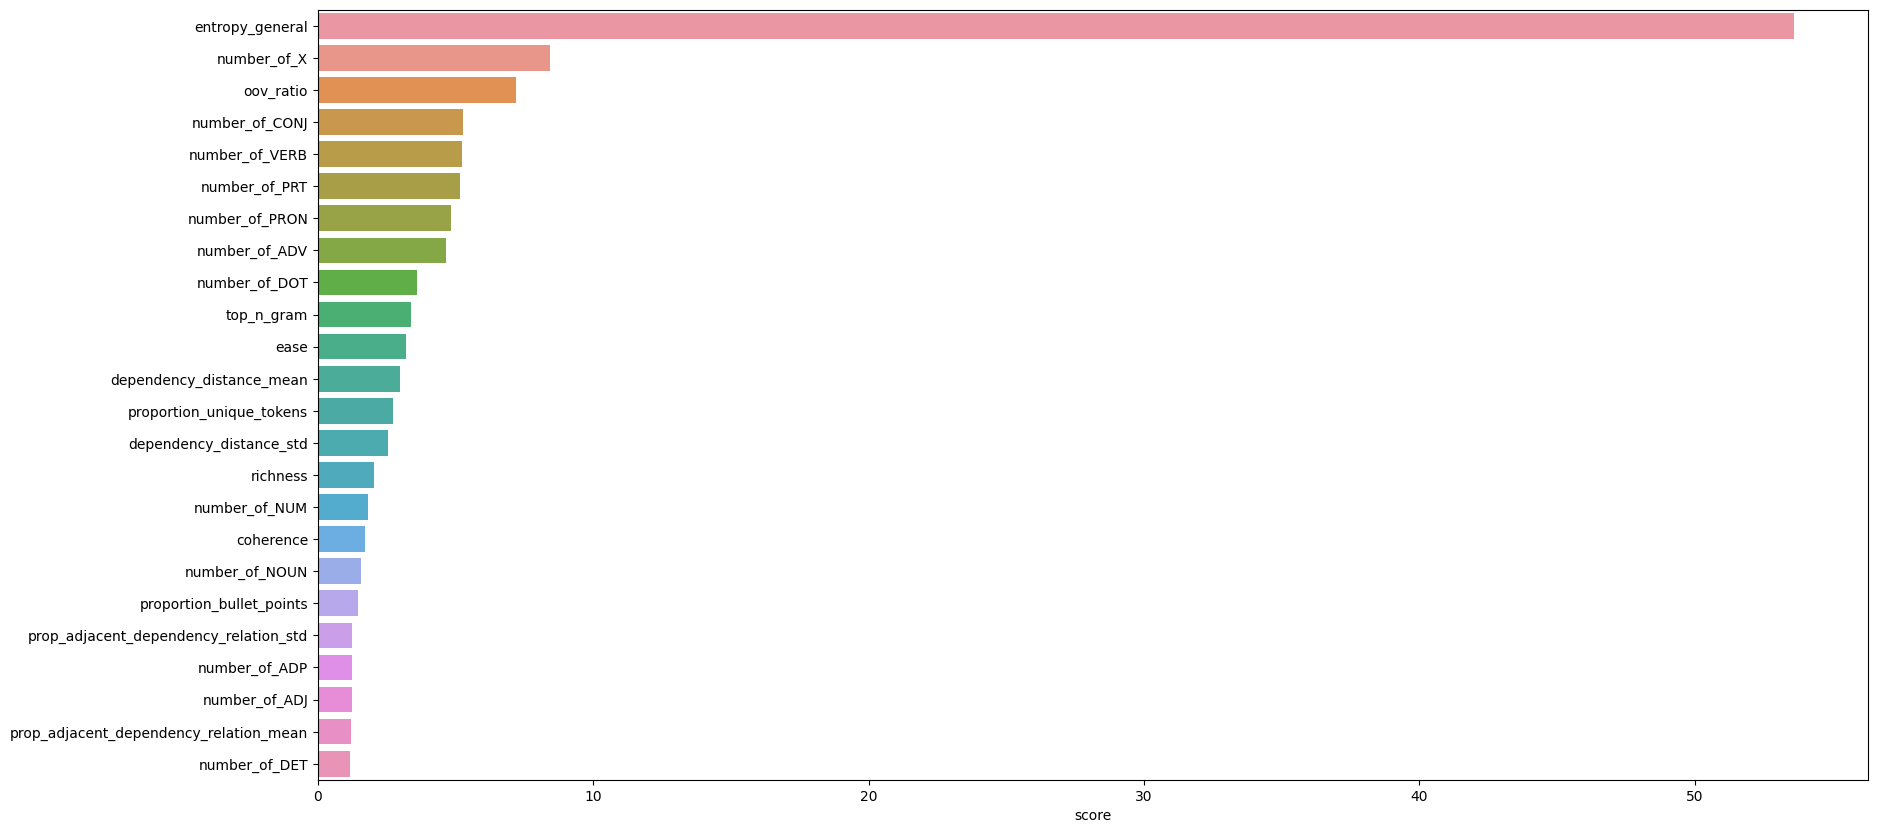

In [ ]:
keys2 = list(final_importances2.keys())
values2 = list(final_importances2.values())

data2 = pd.DataFrame(data=values2, index=keys2, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(data = data2, x = 'score', y = data2.index)

Again, in this model, it is the information theory measures that contribute most to the accuracy improvement during the model's decision-making process. The *oov_ratio* remained in its third position. The creation of the *ease* variable weakened the contribution of its components to the model. The other variables seem to contribute similarly as in the previous model.

# Summary

In this Colab notebook, I present a comprehensive data analysis of differences between human- and ChatGPT-generated texts measured by means of various linguistic metrics.

We delve into the data, employing a variety of statistical techniques, visualizations, and machine learning algorithms to extract meaningful information.

We saw that większość metryk rozkłada się różnie w zależności od klasy (Wikipedia versus ChatGPT). Największe różnice zaobserwowaliśmy w rozkładzie takich miar jak perplexity per token or normalized bigram entropy. Podobne wyniki znaleźć można np u TODO PRZYPIS 

By sharing this notebook, I hope to inspire others to explore the fascinating realm of Large Language Models and provide a valuable resource for researchers, data enthusiasts, and anyone interested in understanding how AI-generated texts differ from those written by humans from a data-driven perspective.